In [4]:
import pandas as pd
from datetime import datetime
from distfit import distfit
import plotly.express as px
from scipy.stats import uniform
from scipy import interpolate

In [8]:
path = ''
price_df = pd.read_csv(path + 'prices_extract.csv')
price_df['Date_full'] = price_df.apply(lambda x: datetime.fromisoformat(x.Date_full), axis=1)
date_start='2021-01-01'

In [9]:
#PRE+ PRE-: valeur à prédire
#px.line(price_df,x='Date_full',y=['PRE+','PRE-','Prix_spot'])

In [10]:
# fonction pour repérer quelle est la saison/quel est le jour afin de séparer les modèles
def compute_seasons_day(df):
    seasons = ['winter', 'winter', 'half-season', 'half-season', 'summer', 'summer', 'summer', 'summer', 'half-season', 'half-season',
               'winter', 'winter']
    df_tmp=df.copy()
    month_to_season = dict(zip(range(1, 13), seasons))
    daylist = ['WD', 'WD', 'WD', 'WD', 'WD', 'saturday', 'sunday']
    daylist = dict(zip(range(0, 7), daylist))

    df_tmp['Season'] = df.apply(lambda x: month_to_season.get(x.Date_full.month), axis=1)
    df_tmp['Day_type'] = df.apply(lambda x: daylist.get(x.Date_full.weekday()), axis=1)

    return df_tmp

In [11]:
# Calcul du critère (ecart delta avec le prix spot ou ratio r)
name=''
mean_day_df = price_df.groupby('Day').mean().reset_index()

price_df['norm_PRE-'] = 1
price_df['mean_spot'] = 1
for i in price_df.Day.unique():
    price_df.loc[price_df['Day'] == i, 'norm_PRE-'] = price_df.loc[price_df['Day'] == i, 'PRE-' + name] / \
                                                      mean_day_df.loc[
                                                          mean_day_df['Day'] == i, 'Prix_spot'].to_numpy()
    price_df.loc[price_df['Day'] == i, 'mean_spot'] = price_df.loc[price_df['Day'] == i, 'Prix_spot'] * \
                                                      mean_day_df.loc[
                                                          mean_day_df['Day'] == i, 'Prix_spot'].to_numpy()
    price_df.loc[price_df['Day'] == i, 'norm_PRE+'] = price_df.loc[price_df['Day'] == i, 'PRE+' + name] / \
                                                      mean_day_df.loc[
                                                          mean_day_df['Day'] == i, 'Prix_spot'].to_numpy()

In [22]:
# price_df = compute_seasons_day(price_df)


In [13]:
#filtre sur une catégorie en particulier
Day_type='WD'
Season='half-season'
Heure=price_df.Heure.unique()


df_res=pd.DataFrame()
for i in Heure:
    price_df_filt = price_df[price_df['Day_type'] == Day_type]
    price_df_filt = price_df_filt[price_df_filt['Season'] == Season]
    price_df_filt = price_df_filt[price_df_filt['Heure'] == i]
    price_df_filt = price_df_filt.sort_values('Date_full').reset_index()
    datam=price_df_filt['norm_PRE-'].to_numpy()
    dist=distfit(distr='t')
    dist.fit_transform(datam)
    df_tmp=dist.summary
    df_tmp['Heure']=i
    df_res=pd.concat((df_res,dist.summary))

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [t] [0.05 sec] [RSS: 0.299136] [loc=0.927 scale=0.207]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [t] [0.04 sec] [RSS: 0.370459] [loc=0.995 scale=0.212]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [t] [0.05 sec] [RSS: 0.549884] [loc=0.792 scale=0.184]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [t] [0.03 sec] [RSS: 0.901511] [loc=0.830 scale=0.197]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [t] [0.04 sec] [RSS: 0.638463] [loc=0.812 scale=0.219]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [t] [0.06 sec] [RSS: 0.823569] [loc=0.83

In [14]:
df_res.head(5)

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color,Heure
0,t,0.299136,0.927014,0.206792,"(2.599362110889518,)","(2.599362110889518, 0.9270144358021046, 0.2067...",<scipy.stats._distn_infrastructure.rv_frozen o...,0,None,#e41a1c,23:30
0,t,0.370459,0.995,0.211837,"(2.4139906533150612,)","(2.4139906533150612, 0.995000082954496, 0.2118...",<scipy.stats._distn_infrastructure.rv_frozen o...,0,None,#e41a1c,00:00
0,t,0.549884,0.792041,0.184348,"(2.777301537309451,)","(2.777301537309451, 0.7920408819713134, 0.1843...",<scipy.stats._distn_infrastructure.rv_frozen o...,0,None,#e41a1c,00:30
0,t,0.901511,0.830141,0.196968,"(2.9068341150874017,)","(2.9068341150874017, 0.8301414582944391, 0.196...",<scipy.stats._distn_infrastructure.rv_frozen o...,0,None,#e41a1c,01:00
0,t,0.638463,0.811914,0.218845,"(3.7213189320784563,)","(3.7213189320784563, 0.8119143303078813, 0.218...",<scipy.stats._distn_infrastructure.rv_frozen o...,0,None,#e41a1c,01:30


[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: T(loc:0.954922, scale:0.213957)


(<Figure size 2000x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'\nt(df=2.34405, loc=0.954922, scale=0.213957)'}, xlabel='Values', ylabel='Frequency'>)

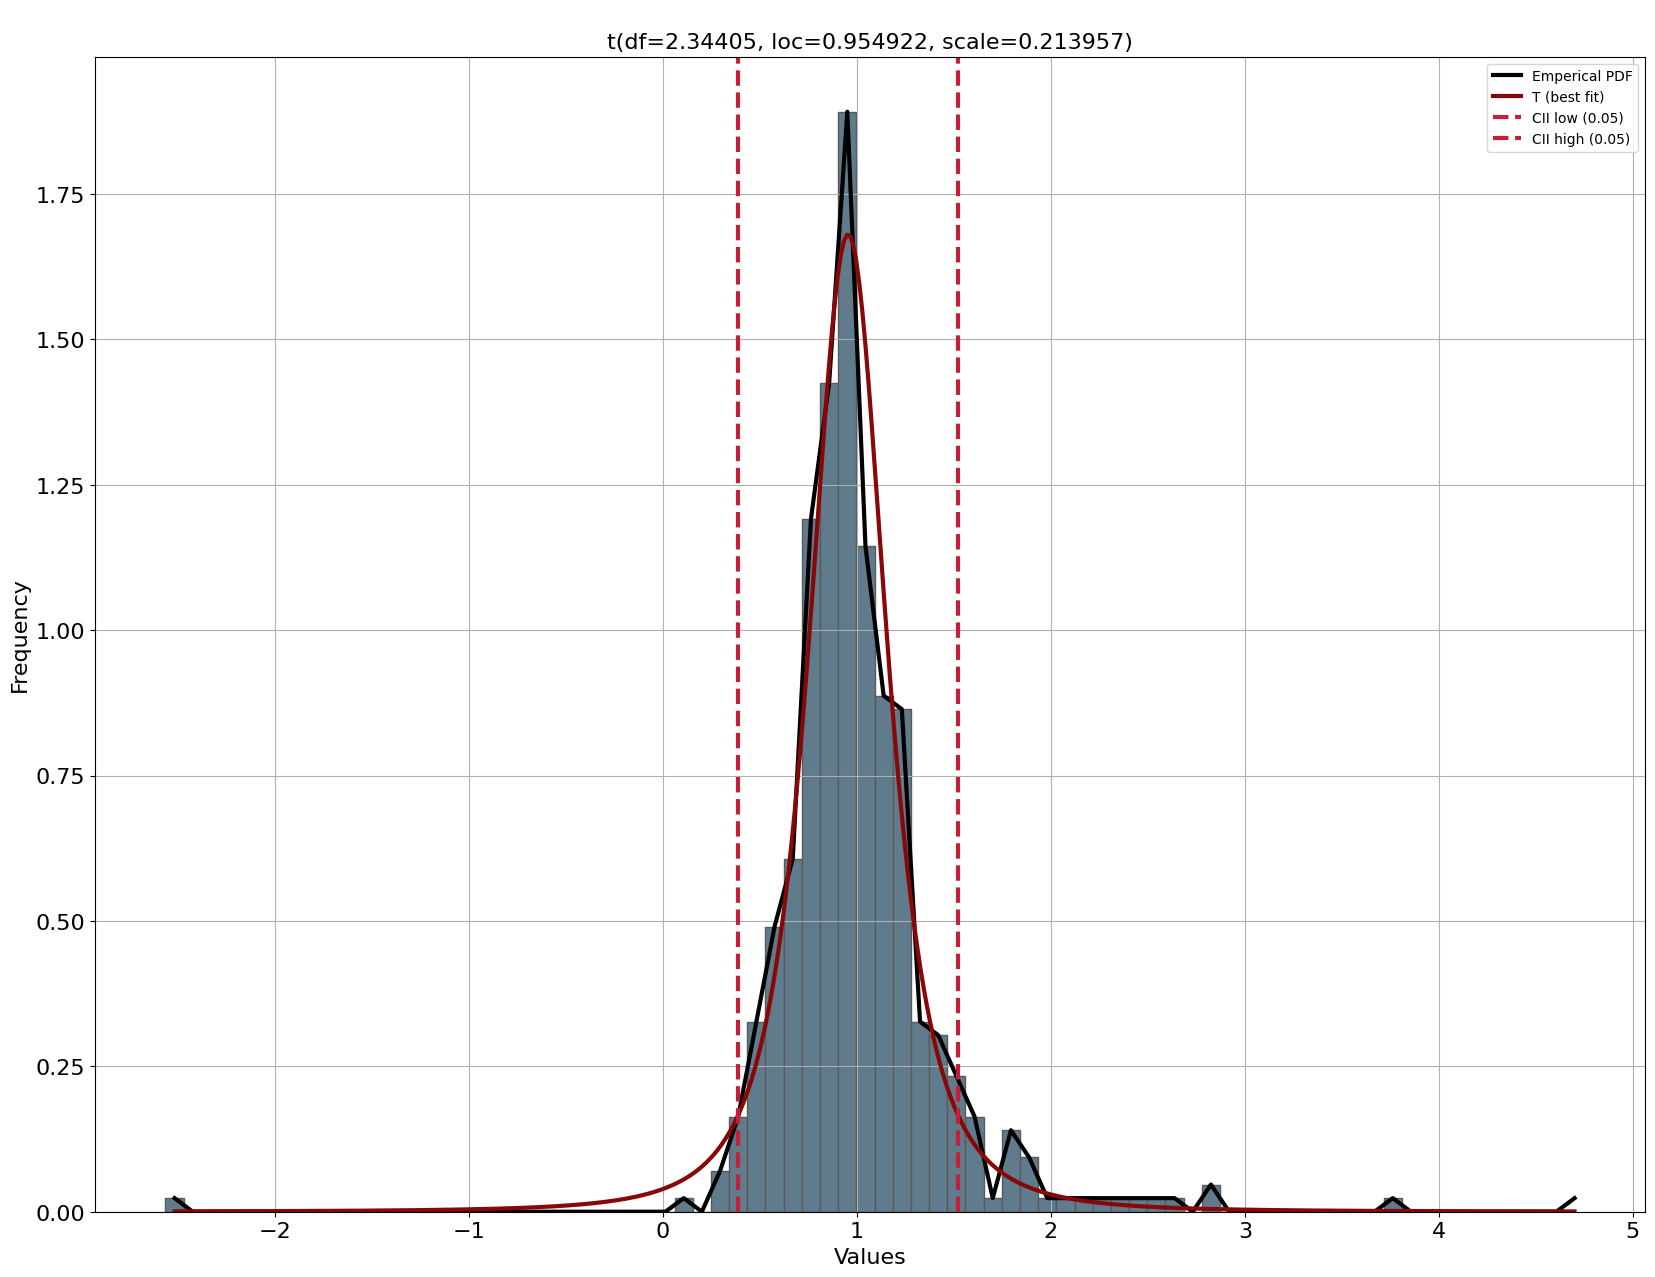

In [15]:
dist.plot()

In [3]:
path = ''
price_df = pd.read_csv(path + 'prices_extract.csv')
df = price_df[['Date_full','Prix_spot']]
data = df.astype('float32')


ValueError: could not convert string to float: '2017-10-01 23:30:00'

In [41]:
# slice the data
a =int(len(df)*0.9) 

train = data[0:a, :]   
test = data[a:, :]     

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [37]:
# slice the data


from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.1)

In [45]:
train

array([['2017-10-01 23:30:00', 25.77],
       ['2017-10-02 00:00:00', 22.52],
       ['2017-10-02 00:30:00', 22.52],
       ...,
       ['2022-05-19 16:00:00', 232.99],
       ['2022-05-19 16:30:00', 232.99],
       ['2022-05-19 17:00:00', 269.27]], dtype=object)

In [46]:
def prepare_data(data, lags=1):
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)    

In [48]:
# prepare the data
lags = 1
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test     # due to naming convention

In [2]:
import pandas as pd

ts_str = '2000-03-10 15:43:10'
ts = pd.to_datetime(ts_str)
print(ts)

ts_str_list = ['2000-03-10 15:43:10', '2000/03/10 15:44']
ts_list = pd.to_datetime(ts_str_list)
print(list(ts_list))

2000-03-10 15:43:10
[Timestamp('2000-03-10 15:43:10'), Timestamp('2000-03-10 15:44:00')]
